In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os

from ImageUtils import *
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
import seaborn as sns

In [3]:
### DEFINE WORKING DIRECTORY
wd = '/Users/akshay/proj/TextureSynthesis'

# Function shortcuts
npand = np.logical_and
sqz = np.squeeze

In [4]:
### Load behavioral data
bd = loadmat(wd + '/behav_data/s352.mat')
td = np.load(wd+'/behav_data/trialDistances2.npy')

# Preprocess the behavioral data a bit.
fix_str_vec = lambda vec: np.array([str(vec[0][i][0]) for i in range(len(vec[0]))], dtype='string_')
for field in ['imNames', 'rfNames', 'layerNames']:
  bd[field] = fix_str_vec(bd[field])
for field in ['layer', 'image', 'rf_size', 'corr_trials', 'ecc']:
  bd[field] = sqz(bd[field])
bd['rf_sz_deg'] = 6.0 / bd['rf_size']
bd['nLayers'] = len(np.unique(bd['layer']))
bd['nRfSizes'] = len(np.unique(bd['rf_size']))

### Plot trial distances as a function of stimulus RF Size / Layer vs observer RF size / layer

In [56]:
# First get all trial distances for each stimulus RF Size
nRFs = len(np.unique(bd['rf_size']))
dist_RFs = np.zeros((nRFs, nRFs))
for rf_sz in np.unique(bd['rf_size']):
    dist_I = td[:,:,bd['rf_size']==rf_sz]
    dist_RFs[rf_sz-1,:] = np.mean(np.mean(dist_I, axis=0), axis=1)

# Then get all trial distances for each stimulus layer
nLayers = len(np.unique(bd['layer']))
dist_layer = np.zeros((nLayers, nLayers))
for layer in np.unique(bd['layer']):
    dist_I = td[:,:,bd['layer']==layer]
    dist_layer[layer-1,:] = np.mean(np.mean(dist_I, axis=1), axis=1)

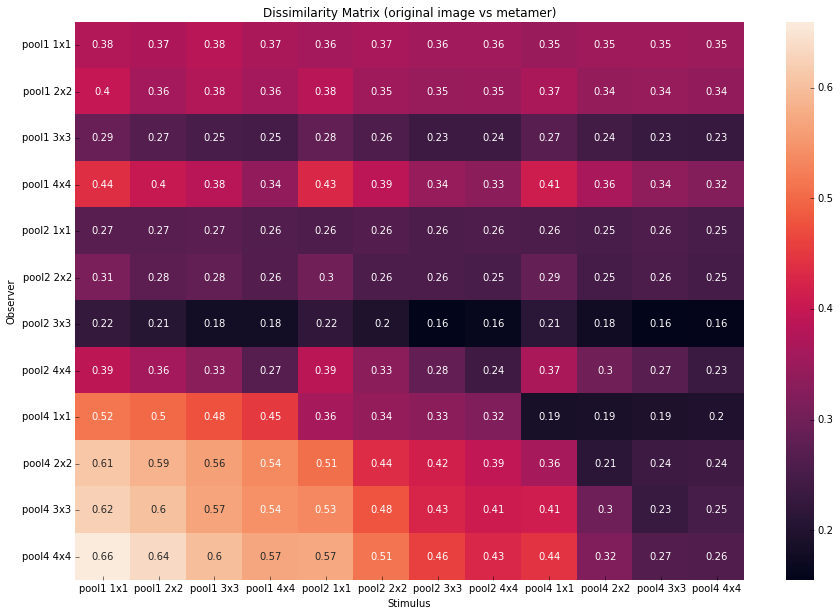

In [21]:
# Get all trial distances for each stimulus RF Size and layer
layers = np.unique(bd['layerNames'])
rfSizes = np.unique(bd['rfNames'])
nLayers = len(np.unique(bd['layer']))
nRFs = len(np.unique(bd['rf_size']))

dist_mtx = np.zeros((nLayers*nRFs, nLayers*nRFs))
obsI = 0; 
tickLabels = []; 
for obsLay in range(len(layers)):
    for obsRF in range(len(rfSizes)):
        stimI = 0;
        for stimLay in np.unique(bd['layer']):
            for stimRF in np.unique(bd['rf_size']):
                distI = td[obsLay,obsRF,npand(bd['layer']==stimLay, bd['rf_size']==stimRF)]
                dist_mtx[obsI, stimI] = np.mean(distI)
                stimI = stimI+1
        obsI = obsI + 1
        tickLabels.append('%s %s' %(bd['layerNames'][obsLay], bd['rfNames'][obsRF]))

# Plot heatmap of dissimilarity matrix
f = plt.figure(figsize = (15,10))
sns.heatmap(dist_mtx, annot=True, xticklabels = tickLabels, yticklabels = tickLabels)
plt.xlabel('Stimulus')
plt.ylabel('Observer')
plt.title('Dissimilarity Matrix (original image vs metamer)')
plt.savefig('Figures/model_distance_mtx.png')

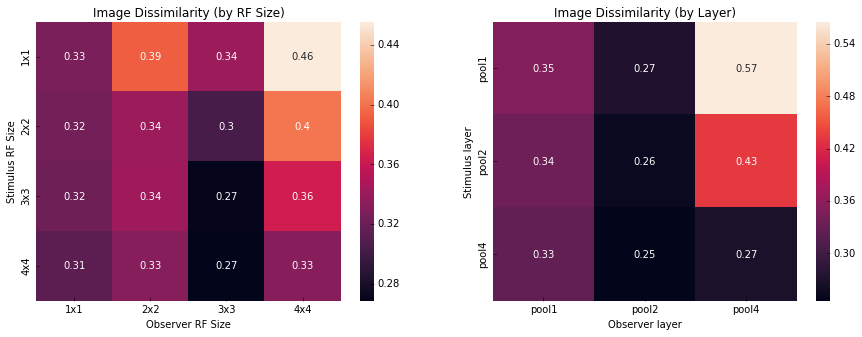

In [61]:
f = plt.figure(figsize = (15,5))
plt.subplot(121)
sns.heatmap(dist_RFs, annot=True, xticklabels=bd['rfNames'], yticklabels=bd['rfNames'])
plt.xlabel('Observer RF Size')
plt.ylabel('Stimulus RF Size')
plt.title('Image Dissimilarity (by RF Size)')

plt.subplot(122)
sns.heatmap(dist_layer, annot=True, xticklabels=bd['layerNames'], yticklabels=bd['layerNames'])
plt.xlabel('Observer layer')
plt.ylabel('Stimulus layer')
plt.title('Image Dissimilarity (by Layer)')

In [ ]:
print 

### Run each of 12 observer models and compare fit to held-out data

In [144]:
# Observer model
obs_RFs = bd['rfNames']
obs_layers = bd['layerNames']
nTrials = int(bd['nTrials'])

# Split out by eccentricity
all_eccs = np.unique(bd['ecc'])

r2s = np.zeros((len(all_eccs), len(obs_RFs), len(obs_layers)))
preds = np.zeros((len(all_eccs), len(obs_RFs), len(obs_layers), 3552))
probabs = np.zeros((len(all_eccs), len(obs_RFs), len(obs_layers)))

correct = bd['corr_trials'][:nTrials]
# Loop through each eccentricity, fit separate model for data from each ecc.
for eccI in range(len(all_eccs)):
    this_ecc = all_eccs[eccI]
    whichEccs = (bd['ecc'] == this_ecc)
    corr_ecc = correct[whichEccs] # Take the subset of trainlabels with this ecc.
    
    cntr = 1
    printStrs = []
    print '~~~ Eccentricity: %d degrees' % (this_ecc)
    for rfI in range(len(obs_RFs)):
        obs_rf = obs_RFs[rfI]
        for layI in range(len(obs_layers)):
            obs_lay = obs_layers[layI]
            trialDist = td[layI, rfI, whichEccs].reshape(-1,1) # Take the subset of trials with this ecc

            # get cross validated predictions.
            logReg = LogisticRegression(class_weight='balanced')
            y_pred = cross_val_predict(logReg, trialDist, corr_ecc, cv=10)
            accuracy = 100.0*np.mean(y_pred==corr_ecc)

            preds[eccI,rfI,layI,:] = y_pred
            
            printStr = 'Model %2i: Observer Layer = %s, RFSize = %s --> \t Accuracy = %.2f%%' \
                        % (cntr, obs_lay, obs_rf, accuracy)
            print printStr
            printStrs.append(printStr)

            cntr = cntr + 1

            if (np.sum(preds) == len(preds) or np.sum(preds) == 0):
                print('\t UH OH! Model is guessing all 1s or all 0s')

    # Joint Model
    trialDist = td[:,:,whichEccs].reshape(len(obs_RFs)*len(obs_layers), np.sum(whichEccs)).T
    logReg = LogisticRegression(class_weight='balanced')
    y_pred = cross_val_predict(logReg, trialDist, corr_ecc, cv=10)
    accuracy = 100.0*np.mean(y_pred==corr_ecc)
    print 'Model %2i: All observer layers/RFs: \t Accuracy = %.2f%%' % (cntr, accuracy)


~~~ Eccentricity: 6 degrees
Model  1: Observer Layer = pool1, RFSize = 1x1 --> 	 Accuracy = 49.38%
Model  2: Observer Layer = pool2, RFSize = 1x1 --> 	 Accuracy = 58.08%
Model  3: Observer Layer = pool4, RFSize = 1x1 --> 	 Accuracy = 63.43%
Model  4: Observer Layer = pool1, RFSize = 2x2 --> 	 Accuracy = 49.77%
Model  5: Observer Layer = pool2, RFSize = 2x2 --> 	 Accuracy = 57.66%
Model  6: Observer Layer = pool4, RFSize = 2x2 --> 	 Accuracy = 66.10%
Model  7: Observer Layer = pool1, RFSize = 3x3 --> 	 Accuracy = 50.79%
Model  8: Observer Layer = pool2, RFSize = 3x3 --> 	 Accuracy = 57.40%
Model  9: Observer Layer = pool4, RFSize = 3x3 --> 	 Accuracy = 66.53%
Model 10: Observer Layer = pool1, RFSize = 4x4 --> 	 Accuracy = 51.52%
Model 11: Observer Layer = pool2, RFSize = 4x4 --> 	 Accuracy = 58.02%
Model 12: Observer Layer = pool4, RFSize = 4x4 --> 	 Accuracy = 66.86%
Model 13: All observer layers/RFs: 	 Accuracy = 67.62%
~~~ Eccentricity: 9 degrees
Model  1: Observer Layer = pool1, RFS

### Plot behavioral data

In [166]:
# Get behavioral data: accuracy by condition

def get_accuracy_by_condition(corr_trials):
    obs_RFs = bd['rfNames']
    obs_layers = bd['layerNames']
    all_eccs = np.unique(bd['ecc'])
    accs = np.zeros((len(all_eccs), len(obs_RFs), len(obs_layers)))
    for eccI in range(len(all_eccs)):
        for rfI in range(len(obs_RFs)):
            for layI in range(len(obs_layers)):
                accs[eccI,rfI,layI] = np.mean(corr_trials[npand(npand(bd['layer']==layI+1, bd['ecc']==all_eccs[eccI]), bd['rf_size']==rfI+1)])
    return accs
    
ct = bd['corr_trials']
accs = get_accuracy_by_condition(ct)


(3, 4, 3)


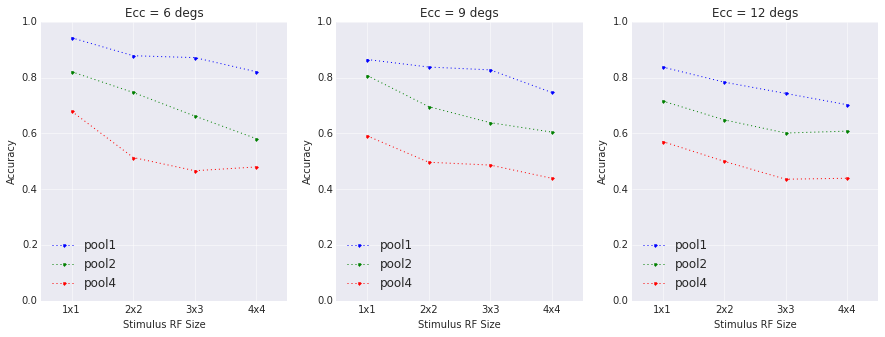

In [106]:
print accs.shape

f = plt.figure(figsize = (15,5))
sns.set_style("darkgrid")

for eccI in range(len(all_eccs)):
    accI = sqz(accs[eccI,:,:])
    
    plt.subplot(1,3,eccI+1)
    plt.plot(accI, '.:')
    plt.xticks(np.arange(4), bd['rfNames'])
    plt.xlim([-.5, 3.5]); plt.ylim([0, 1])
    plt.title('Ecc = %d degs' % (all_eccs[eccI]))
    plt.xlabel('Stimulus RF Size')
    plt.ylabel('Accuracy')
    plt.legend(bd['layerNames'], loc=3)

In [203]:
cntr = 1
preds = np.zeros((len(obs_RFs), len(obs_layers), len(ct)))
probs = np.zeros((len(obs_RFs), len(obs_layers), len(ct)))

for rfI in range(len(obs_RFs)):
    obs_rf = obs_RFs[rfI]
    for layI in range(len(obs_layers)):
        obs_lay = obs_layers[layI]
        trialDist = td[layI, rfI, :].reshape(-1,1) # Take the subset of trials with this ecc

        # get cross validated predictions.
        logReg = LogisticRegression()
        y_pred = cross_val_predict(logReg, trialDist, ct, cv=10)
        y_prob = cross_val_predict(logReg, trialDist, ct, cv=10, method='predict_proba')

        accuracy = 100.0*np.mean(y_pred==ct)
        prob_acc = 100.0*np.mean(y_prob[:,1])

        preds[rfI,layI,:] = y_pred
        probs[rfI,layI,:] = y_prob[:,1]

        printStr = 'Model %2i: Observer Layer = %s, RFSize = %s --> \t Accuracy = %.2f%%; Prob = %.2f%%' \
                    % (cntr, obs_lay, obs_rf, accuracy, prob_acc)
        print printStr
        printStrs.append(printStr)

        cntr = cntr + 1

        if (np.sum(y_pred) == len(y_pred) or np.sum(y_pred) == 0):
            print('\t UH OH! Model is guessing all 1s or all 0s')


Model  1: Observer Layer = pool1, RFSize = 1x1 --> 	 Accuracy = 66.91%; Prob = 66.90%
	 UH OH! Model is guessing all 1s or all 0s
Model  2: Observer Layer = pool2, RFSize = 1x1 --> 	 Accuracy = 66.91%; Prob = 66.91%
	 UH OH! Model is guessing all 1s or all 0s
Model  3: Observer Layer = pool4, RFSize = 1x1 --> 	 Accuracy = 66.23%; Prob = 66.92%
Model  4: Observer Layer = pool1, RFSize = 2x2 --> 	 Accuracy = 66.91%; Prob = 66.91%
	 UH OH! Model is guessing all 1s or all 0s
Model  5: Observer Layer = pool2, RFSize = 2x2 --> 	 Accuracy = 66.91%; Prob = 66.91%
	 UH OH! Model is guessing all 1s or all 0s
Model  6: Observer Layer = pool4, RFSize = 2x2 --> 	 Accuracy = 67.27%; Prob = 66.92%
Model  7: Observer Layer = pool1, RFSize = 3x3 --> 	 Accuracy = 66.91%; Prob = 66.91%
	 UH OH! Model is guessing all 1s or all 0s
Model  8: Observer Layer = pool2, RFSize = 3x3 --> 	 Accuracy = 66.87%; Prob = 66.91%
Model  9: Observer Layer = pool4, RFSize = 3x3 --> 	 Accuracy = 66.99%; Prob = 66.92%
Model 

In [201]:
trialDist = td[:,:,:].reshape(len(obs_RFs)*len(obs_layers), len(ct)).T
print trialDist.shape
logReg = LogisticRegression(class_weight='balanced')
y_pred = cross_val_predict(logReg, trialDist, ct, cv=10)
y_prob = cross_val_predict(logReg, trialDist, ct, cv=10, method='predict_proba')
accuracy = 100.0*np.mean(y_pred==ct)
prob_acc = 100.0*np.mean(y_prob[:,1])
print 'Model %2i: All observer layers/RFs: \t Accuracy = %.2f%%; Prob = %.2f%%' % (cntr, accuracy, prob_acc)


(10656, 12)
Model 13: All observer layers/RFs: 	 Accuracy = 65.47%; Prob = 52.22%


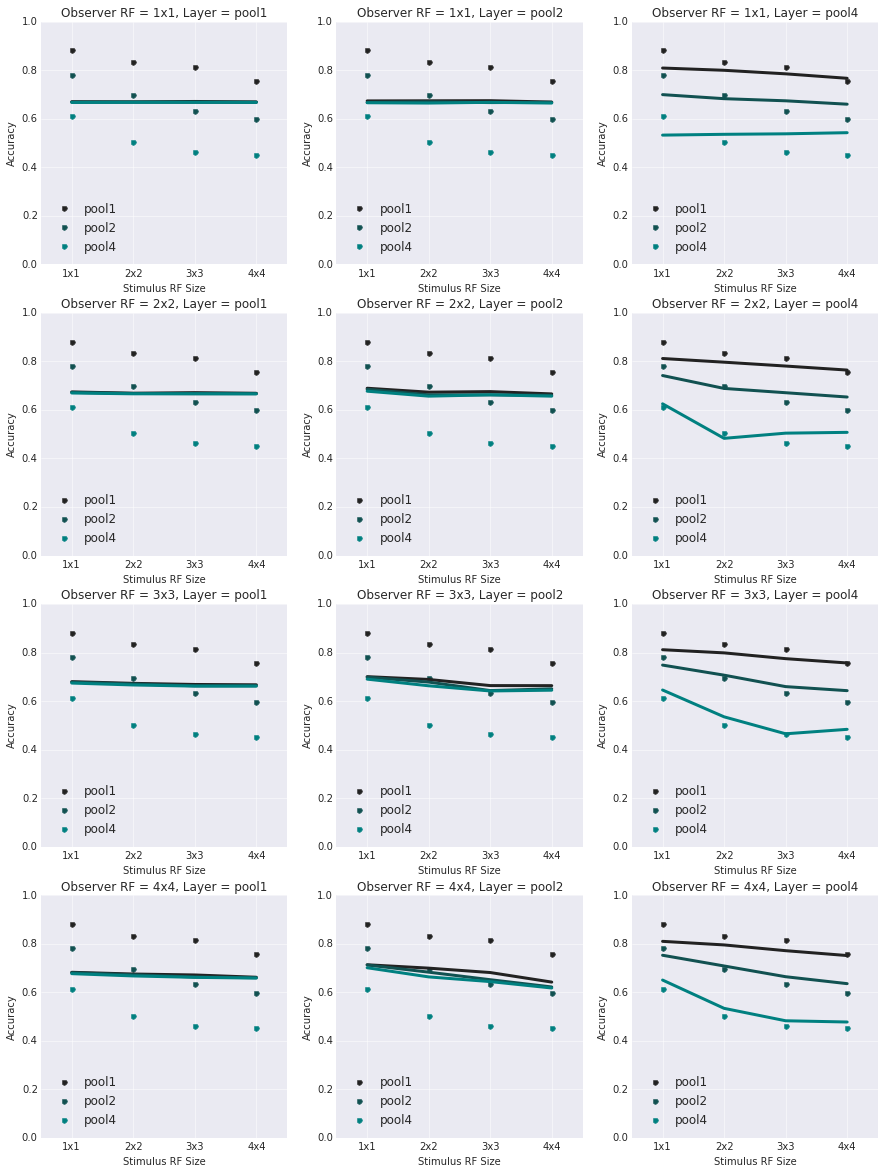

In [274]:
# Preds: 3 eccs x 4 RF sizes x 3 layers x 3552 trials

def plot_3_lines(X,Y,opts,colors, **kwargs):
    for i in range(3):
        plt.plot(X,Y[:,i],opts, color=colors[i], **kwargs)

sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,20))
cntr = 1
colors = sns.dark_palette("teal", n_colors=3)
for rfI in range(len(obs_RFs)):
    obs_rf = obs_RFs[rfI]
    for layI in range(len(obs_layers)):
        obs_lay = obs_layers[layI]
        plt.subplot(4,3,cntr);
        
        # Plot the true 
        acc_true = np.mean(get_accuracy_by_condition(ct), axis=0)
        accs = np.mean(get_accuracy_by_condition(probs[rfI,layI,:]), axis=0) # ignore eccentricity for now
        x=np.arange(4)
        #print x.shape, acc_true.shape
        plot_3_lines(x, acc_true, '.', colors=colors, markersize=10)
        plot_3_lines(x, accs, '-', colors=colors, linewidth=3)

        #plt.plot([0,1,2,3],acc_true, opts='.', markersize=10, linewidth=2)
        #plt.plot(accs, '-', markersize=15, linewidth=4)
        
        
        #plt.plot()
        
        plt.xlim([-.5, 3.5]); plt.ylim([0, 1])
        plt.xlabel('Stimulus RF Size')
        plt.ylabel('Accuracy')
        plt.legend(bd['layerNames'], loc=3)
        plt.title('Observer RF = %s, Layer = %s' % (obs_rf, obs_lay))
        plt.xticks(np.arange(4), bd['rfNames'])    

        cntr = cntr + 1

plt.savefig('Figures/modelFit.png')

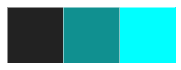

In [265]:
#sns.choose_colorbrewer_palette('s')
sns.palplot(sns.dark_palette('aqua', 3))